# Topic Modeling 
Author: Yanying Jiang

Although we were able to identify some patterns of clusters from the K-Means clustering method, we were not able to tell what are the topics of each cluster. We believe that topic modeling can bring us more insights. One of the most common approaches for topic modeling is Latent Dirichlet Allocation (LDA), which assumes that each document is a mixture of topics, and each topic is a distribution over words.


In order to estimate the topic-word distributions, LDA requires a matrix of word frequencies for each document in the collection.Therefore we use a different feature representation directly extracted from the original dataset, leveraging TF-IDF. By weighting the word frequencies based on their importance in the collection, TF-IDF helps to filter out common and less meaningful words, and highlight the words that are most relevant to the topics. This can improve the accuracy and interpretability of the topic models, by reducing the influence of noise and irrelevant words. We firstly performed lowering, stopwords removal, punctuation removal and stemming on the original dataset, and then used the TF-IDF model provided in Gensim package. 






## Import Packages

In [1]:
# !pip install nltk
# !pip install wordcloud
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import re
from nltk.stem import WordNetLemmatizer
# nltk.download('omw-1.4')
# nltk.download('stopwords')
# nltk.download('wordnet')
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

## Load the Data and Clean the Data

In [2]:
train_df = pd.read_csv("WikiLarge_Train.csv")
test_df = pd.read_csv("WikiLarge_Test.csv") #The testing dataset has no label

In [3]:
train_df.nunique() #Check number of unique items per column

original_text    347356
label                 2
dtype: int64

In [4]:
train_df.isna().sum() #check for Null values 

original_text    0
label            0
dtype: int64

In [5]:
duplicate = train_df[train_df.duplicated()] #take a look at duplicates
 
print("Duplicate Rows :")
duplicate


Duplicate Rows :


,original_text,label
830,__ NOTOC __,1
948,Marklohe is a municipality in the district of ...,1
1021,"At the time , Hurricane Mitch was the stronges...",1
1112,The endorsement test proposed by United States...,1
1208,Founded near the end of the 4th century BC by ...,1
...,...,...
416752,August 9 - Oliver Cromwell divides England int...,0
416753,It is found in the region Aquitaine in the Gir...,0
416761,Individual metropolitan districts range from 4...,0
416762,References,0


In [6]:
# train_df[train_df.original_text == '__ NOTOC __']

In [7]:
train_df.drop_duplicates(subset="original_text",inplace=True)

## Text Pre-processing

In [8]:
stop_word_list = stopwords.words('english')

In [9]:
lemma= WordNetLemmatizer()

def text_preprocess(sentence, stopwords_removal = True):
    '''This function takes in a dataframe, extract and format the text in a standardized format.'''
    sentence = str(sentence)
    sentence = sentence.lower() # lower case
    sentence = re.sub(r'[^a-zA-Z0-9]', r' ', sentence)   # replace these punctuation with space
    sentence = re.sub(r'lrb|rrb', r'', sentence)
    tokens = sentence.split()
    clean_text = []
    for item in tokens:
        if stopwords_removal == True:
            if item not in stop_word_list:
                clean_text.append(lemma.lemmatize(item))
        else:
             clean_text.append(lemma.lemmatize(item))
    clean_text  = " ".join(clean_text)

    return clean_text    

In [10]:
train_df['clean_text'] = train_df['original_text'].apply(lambda x:text_preprocess(x,stopwords_removal = True)) 
test_df['clean_text'] = test_df['original_text'].apply(lambda x:text_preprocess(x,stopwords_removal = True)) 

In [11]:
train_df['clean_text'].replace('', np.nan, inplace=True)
test_df['clean_text'].replace('', np.nan, inplace=True)

In [12]:
train_df[train_df['clean_text'].isna()]

,original_text,label,clean_text
607,! '',1,NaN
1913,-- -RRB-,1,NaN
2118,.,1,NaN
4204,-RRB-,1,NaN
4920,or,1,NaN
...,...,...,...
392600,'' With You '',0,NaN
394815,M&M s,0,NaN
408201,'' The,0,NaN
408254,Most,0,NaN


In [13]:
train_df.dropna(subset=['clean_text'], inplace=True)
test_df.dropna(subset=['clean_text'], inplace=True)
train_df[train_df['clean_text'].isna()]

,original_text,label,clean_text


In [14]:
train_df.head()

,original_text,label,clean_text
0,There is manuscript evidence that Austen conti...,1,manuscript evidence austen continued work piec...
1,"In a remarkable comparative analysis , Mandaea...",1,remarkable comparative analysis mandaean schol...
2,"Before Persephone was released to Hermes , who...",1,persephone released hermes sent retrieve hades...
3,Cogeneration plants are commonly found in dist...,1,cogeneration plant commonly found district hea...
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,geneva second populous city switzerland z rich...


In [15]:
def split_sentence(text):
    return text.split()

In [16]:
X_train =  train_df.clean_text.apply(split_sentence)
X_train

0         [manuscript, evidence, austen, continued, work...
1         [remarkable, comparative, analysis, mandaean, ...
2         [persephone, released, hermes, sent, retrieve,...
3         [cogeneration, plant, commonly, found, distric...
4         [geneva, second, populous, city, switzerland, ...
                                ...                        
416760    [also, worked, timothy, leary, promote, futuri...
416763    [duke, nukem, 3d, version, sold, xbox, live, s...
416764    [however, becoming, replaced, method, executin...
416765        [hand, gesture, hindu, buddhist, iconography]
416766    [necessary, use, color, try, choose, color, co...
Name: clean_text, Length: 347264, dtype: object

## Building the LDA Model

In [17]:
# !pip install gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import TfidfModel

/Users/yanyingj/miniconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


#### Create Dictionary and Corpus from Training data; Build TF-IDF Model

In [18]:
dictionary = Dictionary(X_train)
corpus = [dictionary.doc2bow(x) for x in X_train]
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

#### Parameter Tuning to Find the Optimal Number of Topics
The challenge here is that topic modeling usually takes a long time to converge. Parameter tuning becomes a very slow process. We thus focus on tuning the number of topics, hoping to get an optimal number for topics to interpret. 
The metric we used is the coherence score. The line chart below shows how coherence score changes along with the increase of number of topics. We can see that when the number of topics is 11, we achieved the highest score. We then created the model with the number of topics at 11. 


In [19]:
PYTHONHASHSEED=0

def coherence_computation(dictionary, corpus, texts, limit, start=2, step=3):
    
    coherence_scores = []
    models = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,random_state = 42
                      )
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherencemodel.get_coherence())

    return models, coherence_scores

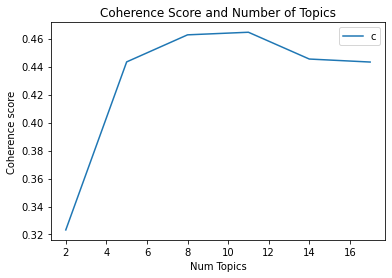

In [98]:
#The code in this cell is inspired by https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

topicmodels, coherence_scores = coherence_computation(dictionary=dictionary, corpus=corpus, texts=X_train, start=2, limit=20, step=3)

limit=20; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_scores"), loc='best')
plt.title("Coherence Score and Number of Topics")
plt.show()

#### Create the Model with the Optimal Number of Topics 

In [99]:
#The code in this cell is inspired by https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

num_topics = 11
chunksize = 500 
passes = 10 
iterations = 50
eval_every = 1  

temp = dictionary[0]  #initiate the dictionary
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

print(lda_model.print_topics())

# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', 
#     level=logging.INFO)

[(0, '0.024*"line" + 0.021*"london" + 0.020*"australia" + 0.019*"son" + 0.018*"hurricane" + 0.016*"white" + 0.014*"2003" + 0.011*"k" + 0.011*"hockey" + 0.011*"local"'), (1, '0.065*"part" + 0.036*"country" + 0.036*"university" + 0.027*"capital" + 0.023*"famous" + 0.023*"largest" + 0.021*"central" + 0.018*"station" + 0.017*"america" + 0.017*"even"'), (2, '0.043*"also" + 0.027*"called" + 0.024*"known" + 0.024*"made" + 0.023*"used" + 0.023*"found" + 0.022*"many" + 0.018*"may" + 0.012*"town" + 0.010*"different"'), (3, '0.036*"name" + 0.024*"district" + 0.020*"west" + 0.019*"east" + 0.018*"number" + 0.018*"language" + 0.018*"word" + 0.016*"around" + 0.015*"including" + 0.014*"mean"'), (4, '0.035*"people" + 0.034*"1" + 0.024*"2" + 0.021*"4" + 0.017*"3" + 0.016*"work" + 0.015*"make" + 0.015*"5" + 0.015*"000" + 0.012*"life"'), (5, '0.038*"new" + 0.018*"series" + 0.017*"september" + 0.017*"book" + 0.016*"show" + 0.014*"november" + 0.013*"2007" + 0.013*"four" + 0.012*"york" + 0.011*"best"'), (6, 

#### Evaluate the model using coherence score and perplexity
With our best model, we were able to achieve a coherence Score of 0.3717 and perplexity of  -11.3356. 

In [22]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=X_train, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.37170925753213185


In [23]:
%%time
# Model Perplexity: 
print("Perplexity: ", lda_model.log_perplexity(corpus))

Perplexity:  -11.33564971532722
CPU times: user 17.7 s, sys: 105 ms, total: 17.8 s
Wall time: 17.8 s


The most frequent terms of each topic are listed below: 

In [34]:
def display_topics(model,num_topics):
    for i in range(0,num_topics):
        term_list = [word[0] for word in lda_model.show_topic(i, topn=10)]
        print("topic %d:" % i, term_list)
display_topics(lda_model,num_topics)

topic 0: ['made', 'many', 'part', 'country', 'music', 'work', 'like', 'show', 'number', 'system']
topic 1: ['first', 'year', 'series', 'member', 'later', 'second', 'day', 'band', 'group', 'different']
topic 2: ['found', 'university', 'make', 'family', 'capital', 'around', 'small', 'largest', 'water', 'large']
topic 3: ['player', 'japanese', 'company', 'great', 'station', 'version', 'built', 'story', 'human', '24']
topic 4: ['1', '2', '4', '3', 'august', 'june', 'c', 'april', 'england', 'february']
topic 5: ['called', 'new', 'used', 'name', 'may', 'september', 'book', 'use', '000', 'british']
topic 6: ['state', 'born', 'city', 'united', 'known', 'football', 'american', 'became', 'county', 'play']
topic 7: ['also', 'one', 'people', 'time', 'two', 'game', 'area', 'south', '5', 'west']
topic 8: ['commune', 'france', 'north', 'de', 'region', 'department', 'district', 'town', 'le', 'several']
topic 9: ['school', 'king', 'main', 'pa', 'calais', 'president', 'ii', 'roman', 'george', 'third']
t

In [26]:
lda_model.save('model.lda')

In [28]:
lda_model = LdaModel.load('model.lda')

#### Visualizing the Topics using Word Cloud

In [52]:
topic_names = []
for i in range(0,num_topics):
    topic_names.append([word[0] for word in lda_model.show_topic(i, topn=30)])

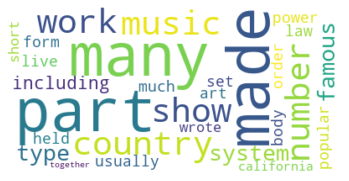

In [94]:
text0 = " ".join([word for word in topic_names[0]])
word_cloud0 = WordCloud(collocations = False, background_color = 'white').generate(text0)
plt.imshow(word_cloud0, interpolation='bilinear')
plt.axis("off")
plt.grid("off")
plt.show()

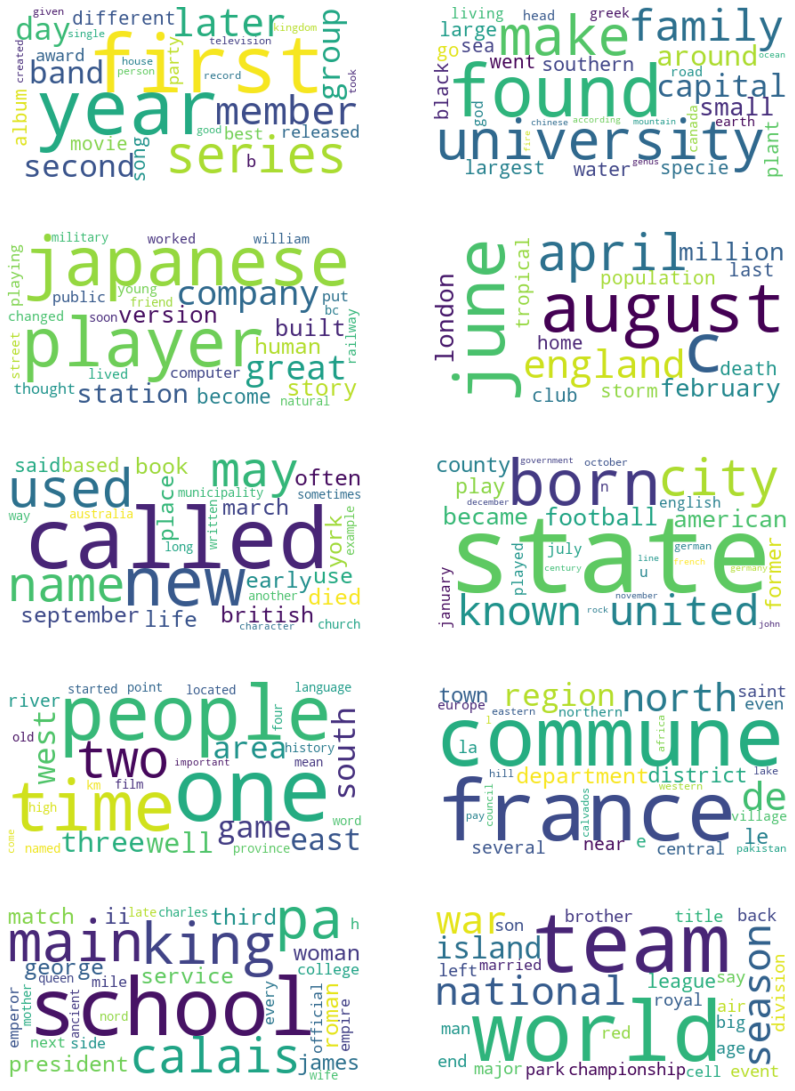

In [93]:
fig, ax = plt.subplots(5,2, figsize = (14,20))


def wordcloud_plot(topic_idx,i):
    text = " ".join([word for word in topic_names[topic_idx]])
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    a = int(i/2)
    b = int(i%2) 
    ax[a,b].imshow(word_cloud, interpolation='bilinear')
    ax[a,b].axis("off")
    ax[a,b].grid("off")
    ax[a,b].get_xaxis().set_ticks([])
    ax[a,b].get_yaxis().set_ticks([])
    ax[a,b].spines['top'].set_visible(False)
    ax[a,b].spines['right'].set_visible(False)
    ax[a,b].spines['bottom'].set_visible(False)
    ax[a,b].spines['left'].set_visible(False)
    


for topic_idx in range(1, num_topics):
    wordcloud_plot(topic_idx,topic_idx-1)


We leverage the pyLDAvis package to visualize the clusters. It has interactive features that allow us to see how topics interact with each other. It provides an intertopic distance map as well as a bar chart for top terms in each topic, making it much easier to interpret our LDA model. 


In [55]:
vis = pyLDAvis.gensim.prepare(topic_model=lda_model,
                              corpus=corpus,
                              dictionary=dictionary)

vis

/Users/yanyingj/miniconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.306611  0.323769       1        1  13.935365
6      0.290871 -0.333864       2        1  13.553705
5     -0.001671 -0.057992       3        1  12.318862
1     -0.054945 -0.020825       4        1  10.504292
0     -0.073736 -0.009061       5        1   9.728972
4     -0.073039 -0.008791       6        1   9.432146
10    -0.090835  0.004681       7        1   7.179474
2     -0.092209  0.006186       8        1   6.708219
9     -0.092770  0.007734       9        1   6.154018
8     -0.026651  0.078182      10        1   5.490199
3     -0.091628  0.009982      11        1   4.994748, topic_info=         Term          Freq         Total Category  logprob  loglift
97      first  21506.000000  21506.000000  Default  30.0000  30.0000
563      also  24281.000000  24281.000000  Default  29.0000  29.0000
1621    state  22660.000000  22660.000000  Default  28.0000  28.0000
527      born  21743.000000  21743.000000  Default  27.0000  27.0000
49       city  20850.000000  20850.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
3352   friend   1670.913838   1672.141253  Topic11  -4.8231   2.9960
1949       bc   1610.225579   1611.452983  Topic11  -4.8601   2.9960
4345  natural   1468.330150   1469.557566  Topic11  -4.9524   2.9959
4677     1984   1456.585443   1457.812854  Topic11  -4.9604   2.9959
3355     soon   1441.787316   1443.014734  Topic11  -4.9706   2.9959

[361 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1524      3  0.999740      000
883       6  0.999909        1
484       6  0.999830       10
148       6  0.999580       12
1884      6  0.999695       15
...     ...       ...      ...
205       3  0.999540  written
2294      5  0.999527    wrote
48        4  0.999914     year
1580      3  0.999743     york
3255     11  0.999264    young

[332 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 6, 2, 1, 5, 11, 3, 10, 9, 4])

### Reference

Kamal Kumar May 3, 2018   https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

Susan Li May 30, 2018 https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

Selva Prabhakaran March 26, 2018  https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda